---
title: "Double Descent in Overparameterized Regression"
author: "Jiffy Lesica"
---

## Abstract:

In this blog post, I explore how feature complexity/quantity affects the performance of linear regression models, particularly in the context of overparameterized optimization. I begin the post by analyzing why the standard solution to regression fails at the interpolation threshold - where the number of features begins to exceed number of data observations. I then implemented an overparameterized linear regression model using the Moore-Penrose pseudoinverse to fit data - linked [here](https://github.com/jiffylesica/jiffylesica.github.io/blob/main/posts/Double%20Descent/logistic.py) - and assessed its ability to learn on 1D data and corrupted image data. By performing a sweep of potential feature numbers - generated with random nonlinear feature maps - I generated training and testing error curves which help clarify double descent through visualization. Specifically, my results show that while performance worsens around the interpolation threshold, it quickly improves as feature count increases beyond data observations, with my lowest testing error occurring with 200 features on a synthetic dataset with 100 observations.

## Part 0

In the provided equation for finding the optimal weight vector in unregularized least-squares linear regression, problems arise when p > n because it disrupts the invertability of the matrix X. 

This specific element of our equation - (X<sup>T</sup>X)<sup>-1</sup> - only works if... well... X<sup>T</sup>X is invertible. However, when p > n, the operation X<sup>T</sup>X produces a matrix which is - according to chapter 11 of our lectures - singular, meaning the columns of the matrix are linearly dependant. In order for a matrix to be invertible, its columns must be linearly independent. If X<sup>T</sup>X, then the whole closed-form solution breaks.

In [138]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from logistic import MyLinearRegression, OverParameterizedLinearRegressionOptimizer

In [139]:
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

## Testing Model on Simple Data

After implementing the MyLinearRegression model and OverParameterized Optimizer in my source code, I verify functionality by trying to fit it to some 1D data.

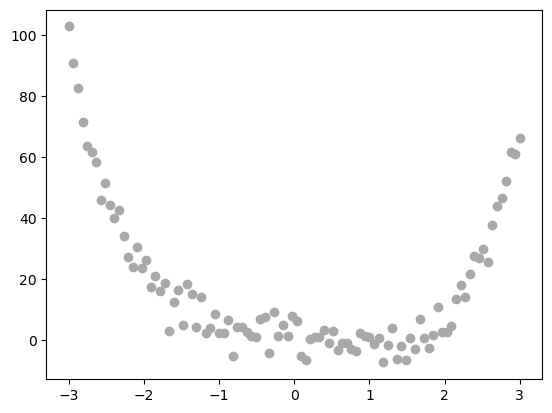

In [140]:
# Generate nonlinear 1D data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

plt.scatter(X, y, color='darkgrey', label='Data')

In [141]:
# Apply polynomial feature map to data
phi = RandomFeatures(8)
phi.fit(X)
X_transformed = phi.transform(X)

In [142]:
# Create and fit regression model
MLR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(MLR)
opt.fit(X_transformed, y)

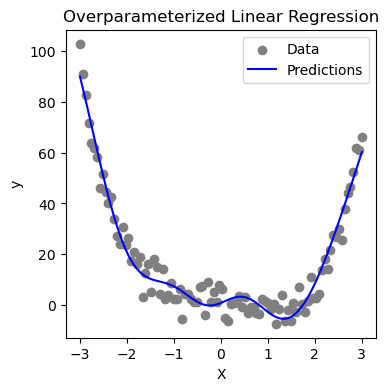

In [143]:
# Predict model on same inputs
y_preds = MLR.predict(X_transformed)

# Plot it!
plt.figure(figsize=(4,4))
# need to convert to numpy bc that is what Matplot works with
plt.scatter(X.numpy(), y.numpy(), label="Data", color='gray')
plt.plot(X.numpy(), y_preds.numpy(), label="Predictions", color='blue')
plt.legend()
plt.title("Overparameterized Linear Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Part C: Double Descent in Image Corruption Detection

Here, I apply my model to a more complicated dataset!

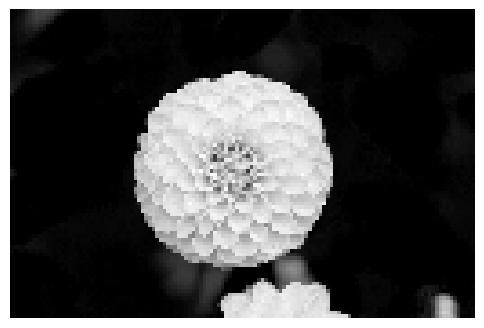

In [144]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower, cmap='gray_r')
off = ax.axis("off")

In [145]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

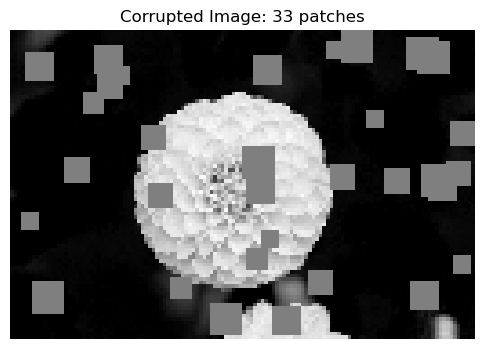

In [146]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1, cmap='gray_r')
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

In [147]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

In [148]:
from sklearn.model_selection import train_test_split

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## My Task: Assess model performance on image corruption prediction as vary n_features in RandomFeatures

*Steps*
1. Train model with different numbers of features
2. Compute training and test Mean Squared Errors (MSEs)
3. Plot Curves
4. plot ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vertical line at interpolation threshold (point where number of features used exceeds number of training samples)

In [149]:
"""
The first step is to train our model on a set of different feature numbers.
So, we perform a sweep over 200 different features numbers - based on provided
reference plots - and keep track of training and testing errors for each number
of features
"""
num_features = list(range(1, 201))
training_errors = []
testing_errors = []

for feats in num_features:
    phi = RandomFeatures(n_features=feats, activation=square)
    phi.fit(X_train)
    X_train_features = phi.transform(X_train)
    X_test_features  = phi.transform(X_test)

    MLR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(MLR)
    opt.fit(X_train_features, y_train)

    MSE_train = MLR.loss(X_train_features, y_train).item()
    MSE_test = MLR.loss(X_test_features, y_test).item()

    training_errors.append(MSE_train)
    testing_errors.append(MSE_test)

min_test_error = min(testing_errors)
min_test_error_index = testing_errors.index(min_test_error)
optimal_num_features = num_features[min_test_error_index]

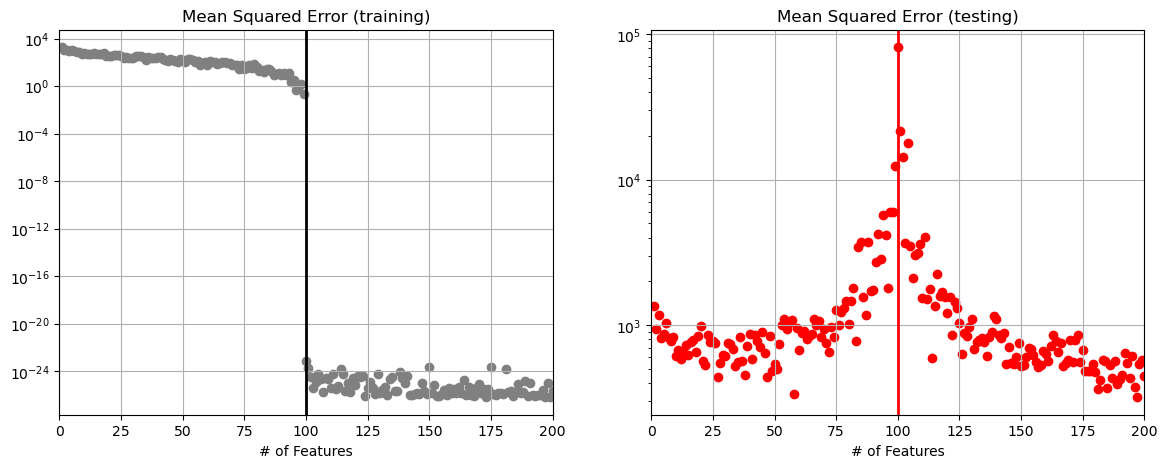

In [150]:
"""
Here, we plot the actual graphs that represent the above feature sweeps results.
Since we know the interpolation threshold is the point where number of features
exceeds number of training samples, we can plot our vertical line at the point where
the number of features equals the number of training samples.
"""

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Training Plot
axes[0].scatter(num_features, training_errors, color='gray')
# Interp threshold is where num features > num training samples
# So, it is when num features = num training samples
axes[0].axvline(x=len(X_train), color='black', linewidth=2)
axes[0].set_yscale("log")
axes[0].set_title("Mean Squared Error (training)")
axes[0].set_xlabel("# of Features")
axes[0].set_xlim(0, 200)
axes[0].grid(True)

axes[1].scatter(num_features, testing_errors, color='red')
axes[1].axvline(x=len(X_train), color='red', linewidth=2)
axes[1].set_yscale("log")
axes[1].set_title("Mean Squared Error (testing)")
axes[1].set_xlabel("# of Features")
axes[1].set_xlim(0, 200)
axes[1].grid(True)

In [151]:
# And now, state the optimal number of features my exploration found
print(f"Lowest Test Error = {min_test_error}, Occurring at {optimal_num_features} features")

Lowest Test Error = 319.56678645266777, Occurring at 197 features


*What is Optimal?* - Based on the results above, the lowest test error was ~287.03, which occurred at 200 features. The interpolation threshold was 100 features - since I trained on 100 data observations - meaning that the optimal number of features occurred above the interpolation threshold.

## Discussion:

This project gave me hands-on experience with the idea of overparameterized training. I was able to explore the complexities of matrix operations, and how the standard closed-form of linear regression fails when number of features exceeds observations due to the nature of matrix invertability. It was fascinating to see how at a point where the math seems to "break," we are actually able to achieve algorithmic improvement once we try and push beyond those boundaries! By sweeping across increasing numbers of features, I was able to visualize how both training and testing errors behave as a model's complexity grows. Most notably, my model achieved its best testing error - or really lowest testing error - when using 200 features, which was twice the number of training data observations I was using. This result confirmed that beyond the interpolation threshold, complexity can actually improve model performance, and reduce overfitting. This blog post ultimately helped me understand more about how machine learning algorithms can excel in high-parameter scenarios, even if the intuition of the math we knew begins to fall apart. What an powerful mystery to unfold!